# Exercises

First, the preparation of the code is done. See exercises below for the answers.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

sns.set_theme(context='notebook',style='white',font_scale=1.5,
              rc = {'axes.spines.top':False,'axes.spines.right':False})


In [2]:
np.random.seed(2)

In [3]:
#Generate stimulus
duration = 50.
dt = .1
std_dev = 1
vf_size = (15,15)
n_bins = round(duration / float(dt))


S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])

In [4]:
#Generate K
size = vf_size # size in pixel of our receptive field
mu = (8, 8) # center of the gabor pathc
sigma = (4,4) #size of the gabor patch
angle = 45 # orientation of the gabor patch
frequency = 0.085 # spatial frequency of the gabor patch
phase = 0 # phase of the gabor pathc


xx, yy = np.meshgrid(1. + np.arange(size[0]),
                         1. + np.arange(size[1]))

# Gaussian envelope
G = np.exp(- np.power(xx - mu[0], 2) / (2. * sigma[0])
            - np.power(yy - mu[1], 2) / (2. * sigma[1]))

# spatial modulation
phi = np.deg2rad(angle)
xxr = xx * np.cos(phi)
yyr = yy * np.sin(phi)
xyr = (xxr + yyr) * 2. * np.pi * 2. * frequency
Sn = np.cos(xyr + phase)

K = G * Sn
K /= np.amax(np.abs(K))

In [5]:
#Generate response
noise_variance = 1
offset = 2.

# flatten the matrices in to 1d array for convenience
K_flat = K.ravel()
K_flat = np.hstack((K.flat, offset))

S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))


# 1. linear stage
ks = np.dot(K_flat, S_flat.T)

# 2. nonlinear stage (for a linear model: f -> identity function)
rate = ks

# add Gaussian noise centered around the "true" rate for each bin
rate = rate + np.sqrt(noise_variance) * np.random.randn(n_bins)

In [6]:
#Fit GLM
K_hat = np.linalg.pinv(S_flat.T @ S_flat) @ (S_flat.T @ rate)
K_hat = K_hat[:-1].reshape(vf_size)

In [7]:
cc = np.inner(K_flat[:-1], K_hat.ravel()) / (np.linalg.norm(K_flat[:-1]) * np.linalg.norm(K_hat.ravel()))

## Exercise 1
---
Determine the effect of stimulus sequence duration on RF estimates. To do this, repeat the above steps for different durations (5 s, 10 s, 20 s, 40 s, 80 s, 160 s, 320 s, 640 s). Compute the Pearson correlation between true and estimated RFs for each duration to quantify the accuracy of the estimator. The Pearson correlation $\mathrm{cc}$ is defined as
$$
\mathrm{cc} = \frac{\mathbf{k}_\mathrm{true}^T \hat{\mathbf{k}}}{\lVert \mathbf{k}_\mathrm{true} \rVert \lVert \hat{\mathbf{k}} \rVert}
$$
where $\lVert \cdot \rVert$ is the L2-norm (vector length).
As the response generation process is stochastic, compute the average correlation across 10 realizations for the same duration and plot the average correlation as a function of duration. How is the recording duration related to the ability to recover the true RF? 

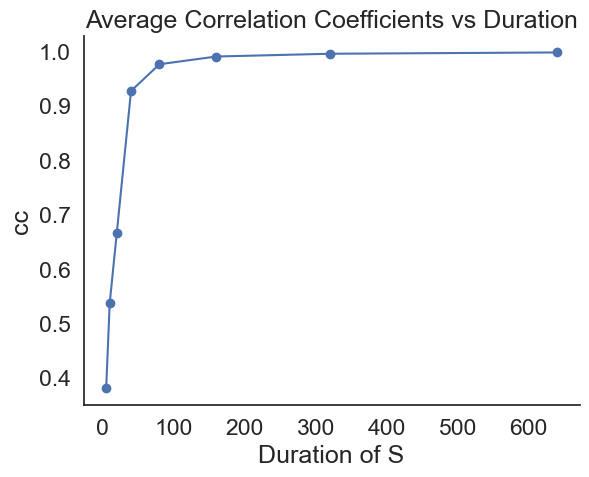

In [8]:
durations = np.array([5, 10, 20, 40, 80, 160, 320, 640])
num_realizations = 10
correlations_avg = np.zeros(len(durations))

for i in range(len(durations)):
    duration = durations[i]
    correlations = np.zeros(num_realizations)
    
    for j in range(num_realizations):
        # Create new S
        n_bins = round(duration / float(dt))
        S = std_dev * np.random.randn(n_bins, vf_size[0], vf_size[1])
        S_flat = S.reshape(S.shape[0], S.shape[1] * S.shape[2])
        S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))

        # Actual response
        ks = np.dot(K_flat, S_flat.T)
        rate = ks + np.sqrt(noise_variance) * np.random.randn(n_bins)

        # Fit GLM
        K_hat = np.linalg.pinv(S_flat.T @ S_flat) @ (S_flat.T @ rate)
        K_hat = K_hat[:-1].reshape(vf_size)

        # Calculate correlations
        correlations[j] = np.inner(K_flat[:-1], K_hat.ravel()) / (
                    np.linalg.norm(K_flat[:-1]) * np.linalg.norm(K_hat.ravel()))

    correlations_avg[i] = np.mean(correlations)

# Plotting average correlations as a function of duration
plt.plot(durations, correlations_avg, marker='o')
plt.xlabel('Duration of S')
plt.ylabel('cc')
plt.title('Average Correlation Coefficients vs Duration')
plt.show()


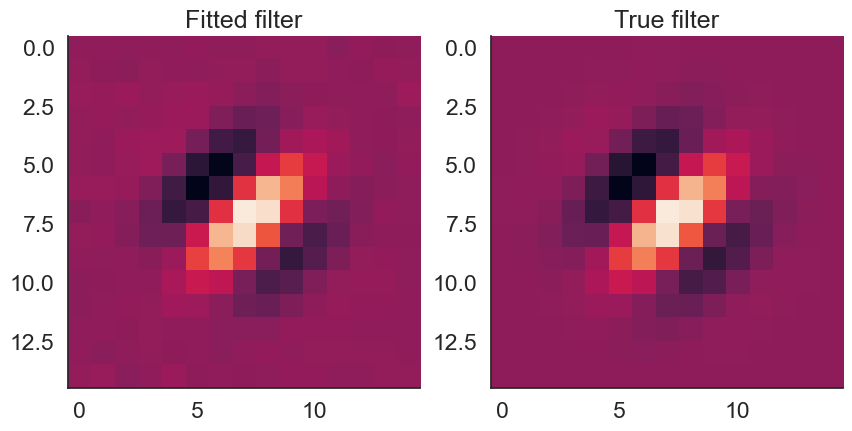

In [9]:
#Show K_hat for the longest duration to check if it works
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('Fitted filter')
plt.imshow(K_hat)
plt.subplot(1,2,2)
plt.title('True filter')
plt.imshow(K)

The recording duration is related to the ability to recover the true receptive field in the following way:

Shorter durations may lead to lower correlation coefficients because there is less information available in the limited time window to accurately estimate the receptive field. The variability introduced by the stochastic nature of the response generation process can have a larger impact on shorter durations.

As the duration increases, more spikes are generated and more information about the stimulus is captured. This additional information can help in recovering the true receptive field, leading to higher correlation coefficients.

However, there is a limit to the improvement in correlation with increasing duration. After a certain point, the additional information gained by extending the duration may become diminishingly small, and the correlation coefficients may plateau.

## Exercise 2
---
Determine the effect of response noise ($\sigma^2$) on RF estimates. Try different value for the noise variance in the simulations, e.g., 0, 2, 4, 6, 8, and 10 for a duration of 100 s. As in the previous excercise, repeatedly estimate RF parameters for each condition (10 times) but this time also plot the standard deviation of the correlations across the different runs for each condition.

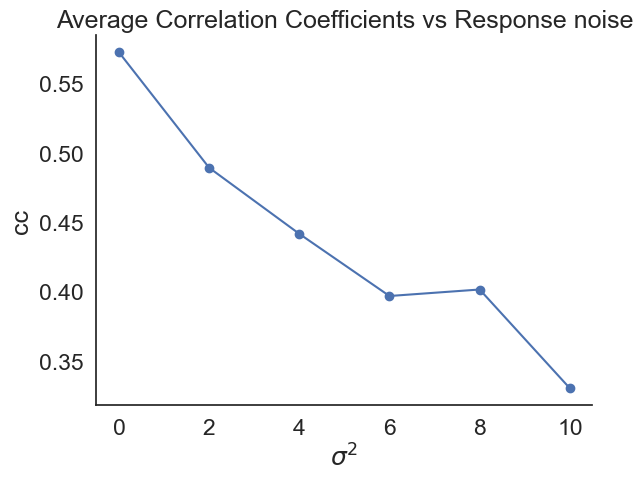

In [10]:
#First for 10 seconds
duration = 10
noise_variances = np.array([0,2,4,6,8,10])
num_realizations = 10
correlations_avg = np.zeros(len(noise_variances))

for i in range(len(noise_variances)):
    noise_variance = noise_variances[i]
    correlations = np.zeros(num_realizations)
    
    for j in range(num_realizations):
        # Create new S
        n_bins = round(duration / float(dt))
        S = std_dev * np.random.randn(n_bins, vf_size[0], vf_size[1])
        S_flat = S.reshape(S.shape[0], S.shape[1] * S.shape[2])
        S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))

        # Actual response
        ks = np.dot(K_flat, S_flat.T)
        rate = ks + np.sqrt(noise_variances[i]) * np.random.randn(n_bins)

        # Fit GLM
        K_hat = np.linalg.pinv(S_flat.T @ S_flat) @ (S_flat.T @ rate)
        K_hat = K_hat[:-1].reshape(vf_size)

        # Calculate correlations
        correlations[j] = np.inner(K_flat[:-1], K_hat.ravel()) / (
                    np.linalg.norm(K_flat[:-1]) * np.linalg.norm(K_hat.ravel()))

    correlations_avg[i] = np.mean(correlations)

# Plotting average correlations as a function of duration
plt.plot(noise_variances, correlations_avg, marker='o')
plt.xlabel('$\sigma^2$')
plt.ylabel('cc')
plt.title('Average Correlation Coefficients vs Response noise')
plt.show()

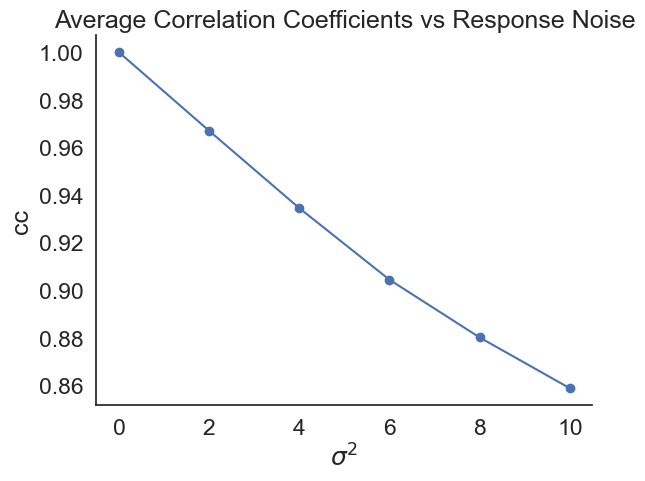

In [11]:
#Now for 100 seconds
duration = 100
noise_variances = np.array([0,2,4,6,8,10])
num_realizations = 10
correlations_avg = np.zeros(len(noise_variances))

for i in range(len(noise_variances)):
    noise_variance = noise_variances[i]
    correlations = np.zeros(num_realizations)
    
    for j in range(num_realizations):
        # Create new S
        n_bins = round(duration / float(dt))
        S = std_dev * np.random.randn(n_bins, vf_size[0], vf_size[1])
        S_flat = S.reshape(S.shape[0], S.shape[1] * S.shape[2])
        S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))

        # Actual response
        ks = np.dot(K_flat, S_flat.T)
        rate = ks + np.sqrt(noise_variances[i]) * np.random.randn(n_bins)

        # Fit GLM
        K_hat = np.linalg.pinv(S_flat.T @ S_flat) @ (S_flat.T @ rate)
        K_hat = K_hat[:-1].reshape(vf_size)

        # Calculate correlations
        correlations[j] = np.inner(K_flat[:-1], K_hat.ravel()) / (
                    np.linalg.norm(K_flat[:-1]) * np.linalg.norm(K_hat.ravel()))

    correlations_avg[i] = np.mean(correlations)

# Plotting average correlations as a function of duration
plt.plot(noise_variances, correlations_avg, marker='o')
plt.xlabel('$\sigma^2$')
plt.ylabel('cc')
plt.title('Average Correlation Coefficients vs Response Noise')
plt.show()

The correlation coefficients seem to decrease as a function of response noise. Higher amounts of noise in the response of a neuron will decrease the amount of information that is gained in a given time window and hence, it will decrease the correlation between the estimated and true RFs.

However, increasing the duration of the stimuli can counteract the amount of information loss. More information is available for the fit procedure, leading to a better estimate of RF and higher correlation coefficients. This can be seen in the seconds graph, the correlation coefficients are higher for a duration of 100 seconds compared to that of a duration of 10 seconds.

## Exercise 3
---
What happens if the neural response is related to the filtered stimulus by a nonlinear function  $r = f_\mathrm{nonlinear}(\mathbf{k}^T \mathbf{s})$, e.g., by setting the `f_nonlin` argument in the data generation function to `f_threshold_quadratic` in excercise 1? Why does the linear estimator still provide a reliable estimate of the true RF? What happens if you use a full quadratic nonlinearity and set the `offset` term to 0? For more details, see Sharpee Ann Rev Neurosci (2013) (link in "Background" section).

## Exercise 4
---
Look at the analytical derivation of the log-likelihood for the poisson GLM.
Which of the terms are required for maximizing the likelihood with respect to $\mathbf{k}$ and which terms can be ignored? **Note:** due to the independence of spikes in the different bins, the likelihood can be written as $P(R | S, \mathbf{k}) = \prod_t^T P(r_t | \mathbf{s}_t, \mathbf{k})$. The log turns the product into a sum which makes life much easier. 




## Exercise 5
---
Explore the effect of the data duration and the firing rate on the goodness of fit of the Poisson GLM.

A - Generate data with durations of 10,20,50,100 and 200 seconds. Fit the model on each dataset and plot the fitted parameters.
Use the pearson correlation as a proxy of the goodness of fit, and plot it as a function of the duration of the data.

B - Fix the duration to 100s, and change the average firing rate of the simulation. How does the fit perform for different firing rates? 

In [12]:
from scipy.optimize import minimize

# define functions

def cost(k, spike_counts, S,alpha=1):
    #negative loglikelihood function to minimize
    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(spike_counts, ks) + dt * np.sum(lamda)
    
    
def grad(k, spike_counts, S):
    # expression of the gradient of the negative log likelihood (note the sign is flipped accordingly)

    ks = np.dot(k, S.T)
    lamda = np.exp(ks)
    return -np.dot(S.T, spike_counts - dt*lamda)

def generate_inhomogeneous_poisson_spikes(lamda, dt):

    n_bins = lamda.shape[0]
    bins = np.arange(n_bins+1)*dt

    # generate Poisson distributed numbers for all bins with the max. intensity (lamda_max)
    lamda_max = np.max(lamda)
    poisson_numbers = np.random.poisson(lamda_max, size=n_bins)

    # throw away numbers depending on the actual intensity ("thinning")
    spike_times = []
    prob = lamda / lamda_max
    for i in range(n_bins):
        
        # number of spikes to keep in this bin
        n = np.sum(np.random.rand(poisson_numbers[i]) < prob[i])
        n_s = int(round(n * dt))

        # generate random spike times in this bin
        ts = bins[i] + np.random.rand(n_s)*dt

        spike_times.extend(ts)

    return np.asarray(spike_times)

## A

/var/folders/9x/_cy0g2js5gd9sl9zbqxlqlsw0000gn/T/ipykernel_45278/69436639.py:8: RuntimeWarning: overflow encountered in exp
  lamda = np.exp(ks)
/var/folders/9x/_cy0g2js5gd9sl9zbqxlqlsw0000gn/T/ipykernel_45278/69436639.py:16: RuntimeWarning: overflow encountered in exp
  lamda = np.exp(ks)
/var/folders/9x/_cy0g2js5gd9sl9zbqxlqlsw0000gn/T/ipykernel_45278/69436639.py:8: RuntimeWarning: overflow encountered in exp
  lamda = np.exp(ks)


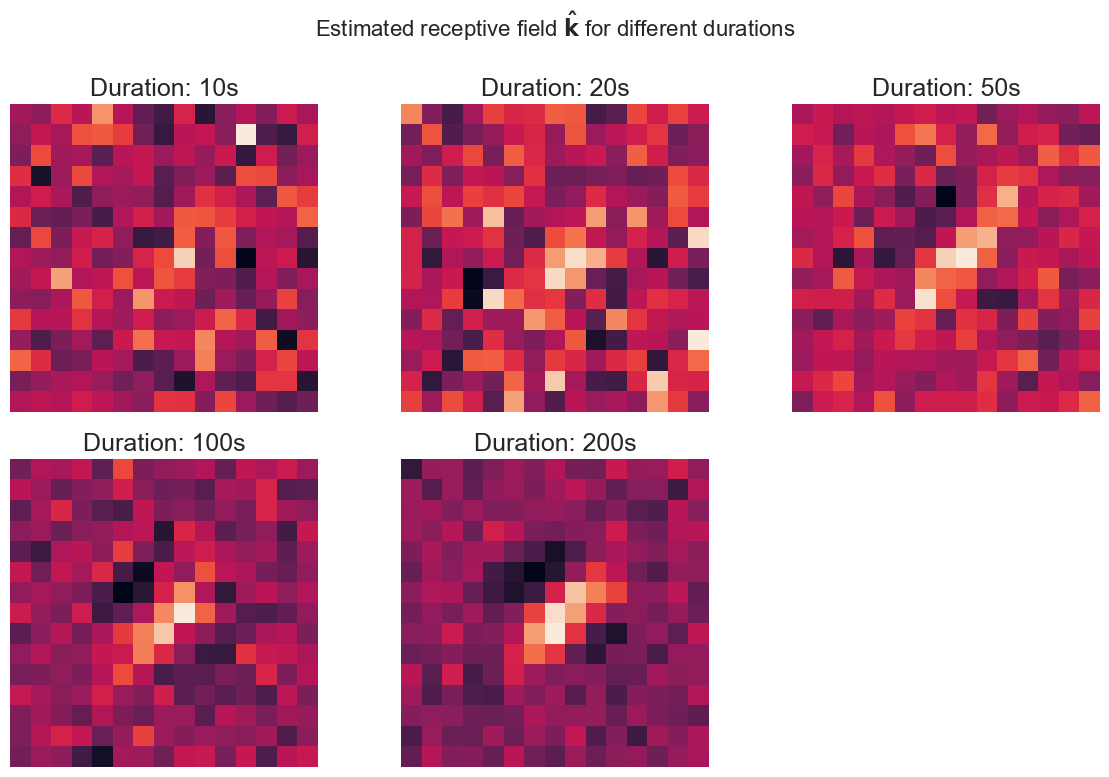

Text(0.5, 1.0, 'Average Correlation Coefficients vs Duration of S')

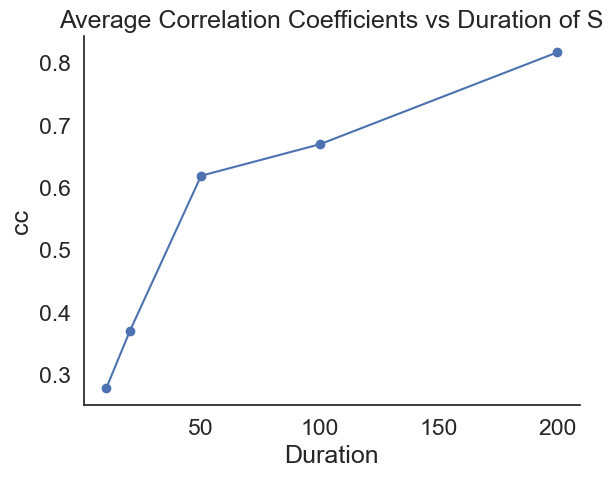

In [13]:
durations = np.array([10,20,50,100,200])
dt = .1
std_dev = 1
vf_size = (15,15)
n_bins = round(duration / float(dt))
spike_rate = 5 # average firing rate 

#store all K matrices for plotting later
K_est_matrices = np.zeros((15,15,len(durations)))

#store correlations
correlations = np.zeros(len(durations))

for i in range(len(durations)):
    duration = durations[i]
    n_bins = round(duration / float(dt))
    #generate stimulus
    S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])
    S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
    S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))
    #actual response
    ks = np.dot(K_flat, S_flat.T)
    lamda = np.exp(ks)
    expected_rate = np.sum(lamda*dt) / duration
    lamda *= (spike_rate / expected_rate)
    #poisson process
    spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)
    spike_counts = np.histogram(spike_times,bins=np.arange(n_bins+1)*dt)[0]
    #fit GLM
    k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
    res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S_flat), method = 'Newton-CG', jac = grad)
    K_est = res.x
    K_est_matrices[:,:,i] = K_est[:-1].reshape(15, 15)
    correlations[i] = np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1]))
    
#plotting K
fig = plt.figure(figsize=(12, 8))

for i in range(len(durations)):
    plt.subplot(2, 3, i+1)
    plt.imshow(K_est_matrices[:,:,i])
    plt.title('Duration: {}s'.format(durations[i]))
    plt.axis('off')

plt.suptitle('Estimated receptive field $\mathbf{\hat{k}}$ for different durations', fontsize=16)
plt.tight_layout()
plt.show()

#plotting cc
plt.plot(durations, correlations,marker='o')
plt.xlabel('Duration')
plt.ylabel('cc')
plt.title('Average Correlation Coefficients vs Duration of S')

The correlation coefficients also increase with increasing duration with the Poisson GLM, as expected. However, the magnitude of the correlation coefficients is lower than that of the linear case. This follows from the fact that there is an additional uncertainty from the Poisson process.

## B

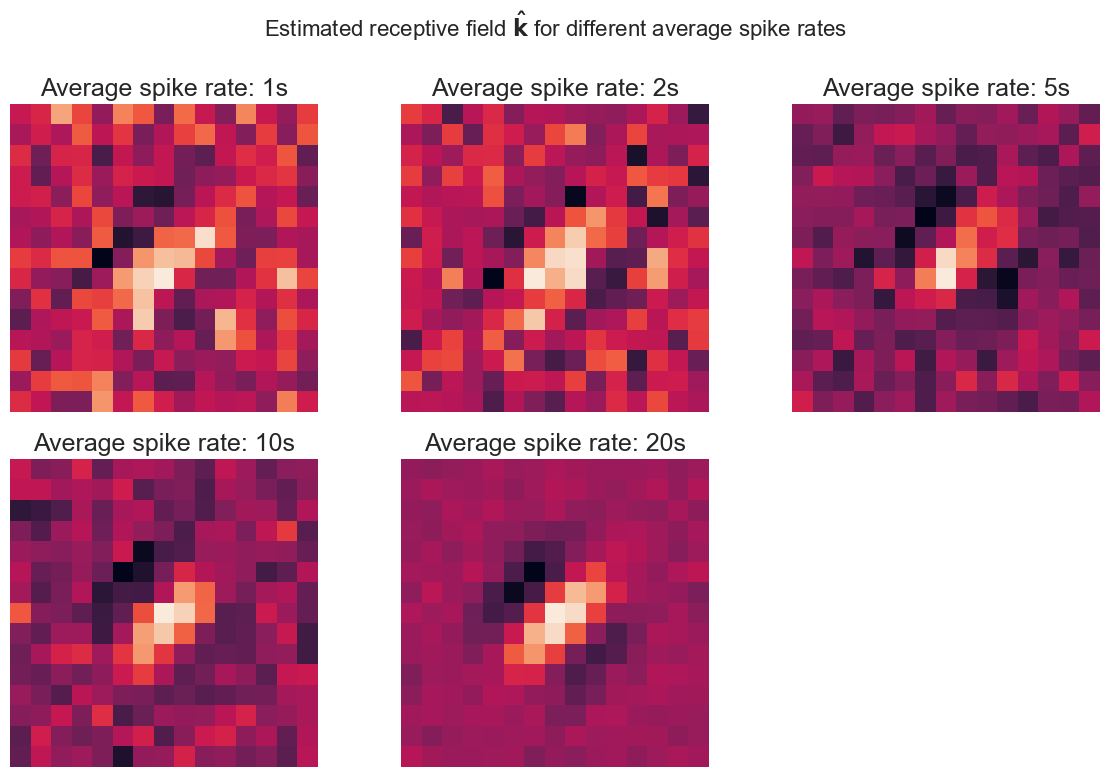

Text(0.5, 1.0, 'Average Correlation Coefficients vs Average Spike Rate')

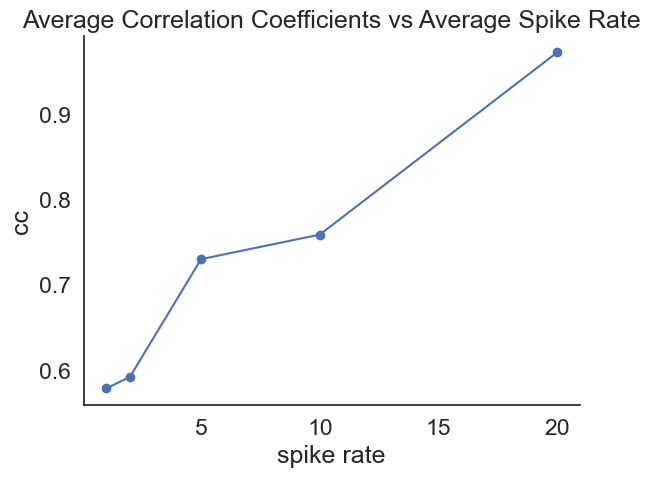

In [14]:
duration = 100
dt = .1
std_dev = 1
vf_size = (15,15)
n_bins = round(duration / float(dt))
spike_rates = np.array([1,2,5,10,20]) # average firing rate 

#store all K matrices for plotting later
K_est_matrices = np.zeros((15,15,len(durations)))

#store correlations
correlations = np.zeros(len(durations))
    
for i in range(len(durations)):
    #generate stimulus
    S = std_dev * np.random.randn(n_bins,vf_size[0],vf_size[1])
    S_flat = S.reshape(S.shape[0],S.shape[1]*S.shape[2])
    S_flat = np.hstack((S_flat, np.ones((n_bins, 1))))
    #actual response
    ks = np.dot(K_flat, S_flat.T)
    lamda = np.exp(ks)
    expected_rate = np.sum(lamda*dt) / duration
    lamda *= (spike_rates[i] / expected_rate)
    #poisson process
    spike_times = generate_inhomogeneous_poisson_spikes(lamda, dt)
    spike_counts = np.histogram(spike_times,bins=np.arange(n_bins+1)*dt)[0]
    #fit GLM
    k_STA = np.inner(S_flat.T, spike_counts) / np.sum(spike_counts)
    res = minimize(fun = cost, x0 = k_STA / 10, args = (spike_counts, S_flat), method = 'Newton-CG', jac = grad)
    K_est = res.x
    K_est_matrices[:,:,i] = K_est[:-1].reshape(15, 15)
    correlations[i] = np.inner(K.ravel(), K_est[:-1]) / (np.linalg.norm(K.ravel()) * np.linalg.norm(K_est[:-1]))
    
#plotting K
fig = plt.figure(figsize=(12, 8))

for i in range(len(durations)):
    plt.subplot(2, 3, i+1)
    plt.imshow(K_est_matrices[:,:,i])
    plt.title('Average spike rate: {}s'.format(spike_rates[i]))
    plt.axis('off')

plt.suptitle('Estimated receptive field $\mathbf{\hat{k}}$ for different average spike rates', fontsize=16)
plt.tight_layout()
plt.show()


#plotting cc
plt.plot(spike_rates, correlations,marker='o')
plt.xlabel('spike rate')
plt.ylabel('cc')
plt.title('Average Correlation Coefficients vs Average Spike Rate')

The correlation coefficients seem to increase with increasing average spike rates. This is probably caused by the fact that a higher average spike rate increases the signal to noise ratio, and hence the amount of information increases leading to a higher correlation coefficient.